Instalación de Librerías

In [13]:
print("Instalando librerías necesarias...")
print("=" * 60)

# Instalar Gymnasium (reemplazo moderno de OpenAI Gym)
!pip install gymnasium -q
!pip install pygame -q  # Para visualización
!pip install seaborn -q
!pip install pandas -q

print("Todas las librerías instaladas correctamente\n")

# Importar librerías
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import time
from IPython.display import clear_output, display, HTML
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficas
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("Librerías importadas:")
print(f"   • Gymnasium versión: {gym.__version__}")
print(f"   • NumPy versión: {np.__version__}")
print(f"   • Matplotlib versión: {plt.matplotlib.__version__}")
print("\nConfiguración inicial completa!")

Instalando librerías necesarias...
Todas las librerías instaladas correctamente

Librerías importadas:
   • Gymnasium versión: 1.2.2
   • NumPy versión: 2.0.2
   • Matplotlib versión: 3.10.0

Configuración inicial completa!


Explorar el Entorno Taxi-v3

In [14]:
print("EXPLORANDO EL ENTORNO TAXI-V3")
print("=" * 60)

# Crear entorno
env = gym.make('Taxi-v3', render_mode='ansi')

# Obtener información del entorno
n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"\n Características del entorno:")
print(f"   • Número de estados posibles: {n_states}")
print(f"   • Número de acciones posibles: {n_actions}")
print(f"   • Espacio de observación: {env.observation_space}")
print(f"   • Espacio de acciones: {env.action_space}")

# Nombres de las acciones
action_names = {
    0: "  Sur (Down)",
    1: "  Norte (Up)",
    2: "  Este (Right)",
    3: "  Oeste (Left)",
    4: " Recoger pasajero (Pickup)",
    5: " Dejar pasajero (Dropoff)"
}

print(f"\n Acciones disponibles:")
for action_id, action_name in action_names.items():
    print(f"   {action_id}: {action_name}")

# Resetear y mostrar estado inicial
state, info = env.reset(seed=42)
print(f"\n Estado inicial aleatorio: {state}")
print(f"\n Visualización del entorno:")
print(env.render())

print("\n Leyenda:")
print("   🟦 R, G, Y, B: Ubicaciones de recogida/entrega")
print("   🟨 Amarillo: Taxi vacío")
print("   🟩 Verde: Taxi con pasajero")
print("   🟪 Magenta: Ubicación de recogida")
print("   🟦 Azul: Destino")
print("   | : Paredes")

env.close()

EXPLORANDO EL ENTORNO TAXI-V3

 Características del entorno:
   • Número de estados posibles: 500
   • Número de acciones posibles: 6
   • Espacio de observación: Discrete(500)
   • Espacio de acciones: Discrete(6)

 Acciones disponibles:
   0:   Sur (Down)
   1:   Norte (Up)
   2:   Este (Right)
   3:   Oeste (Left)
   4:  Recoger pasajero (Pickup)
   5:  Dejar pasajero (Dropoff)

 Estado inicial aleatorio: 386

 Visualización del entorno:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



 Leyenda:
   🟦 R, G, Y, B: Ubicaciones de recogida/entrega
   🟨 Amarillo: Taxi vacío
   🟩 Verde: Taxi con pasajero
   🟪 Magenta: Ubicación de recogida
   🟦 Azul: Destino
   | : Paredes


Clase Q-Learning Agent (PARTE 1 - Inicialización)

Implementa el algoritmo Q-Learning usando una tabla Q (Q-Table) para
aprender la política óptima mediante interacción con el entorno.

In [15]:
print("Creando clase QLearningAgent...")

class QLearningAgent:
    """
    Agente de Q-Learning para resolver el entorno Taxi-v3.
    """

    def __init__(
        self,
        env: gym.Env,
        learning_rate: float = 0.1,
        discount_factor: float = 0.99,
        epsilon: float = 1.0,
        epsilon_decay: float = 0.995,
        min_epsilon: float = 0.01
    ):
        """
        Inicializa el agente Q-Learning.

        Parámetros:
        -----------
        env : gymnasium.Env
            Entorno de Gymnasium (Taxi-v3)
        learning_rate : float (default=0.1)
            Tasa de aprendizaje (α) - controla cuánto se actualizan los Q-values
        discount_factor : float (default=0.99)
            Factor de descuento (γ) - importancia de recompensas futuras
        epsilon : float (default=1.0)
            Probabilidad inicial de exploración
        epsilon_decay : float (default=0.995)
            Factor de decaimiento de epsilon por episodio
        min_epsilon : float (default=0.01)
            Valor mínimo de epsilon (siempre mantener algo de exploración)
        """
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_initial = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Obtener dimensiones del espacio
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n

        # Inicializar Q-table con ceros
        # Q-table[estado, acción] = Q-value
        self.q_table = np.zeros((self.n_states, self.n_actions))

        # Estadísticas de entrenamiento
        self.training_rewards = []
        self.training_epsilons = []
        self.training_steps = []

        # Mostrar configuración
        print(f"\n{'='*60}")
        print(f" AGENTE Q-LEARNING INICIALIZADO")
        print(f"{'='*60}")
        print(f"\n Configuración del Agente:")
        print(f"   • Estados totales: {self.n_states:,}")
        print(f"   • Acciones totales: {self.n_actions}")
        print(f"   • Dimensión Q-table: {self.q_table.shape}")
        print(f"   • Memoria Q-table: {self.q_table.nbytes / 1024:.2f} KB")
        print(f"\n  Hiperparámetros:")
        print(f"   • Learning rate (α): {self.lr}")
        print(f"   • Discount factor (γ): {self.gamma}")
        print(f"   • Epsilon inicial: {self.epsilon}")
        print(f"   • Epsilon decay: {self.epsilon_decay}")
        print(f"   • Epsilon mínimo: {self.min_epsilon}")
        print(f"\n")

    def choose_action(self, state: int) -> int:
        """
        Selecciona una acción usando la estrategia epsilon-greedy.

         ESTRATEGIA EPSILON-GREEDY:
        - Con probabilidad ε: EXPLORACIÓN (acción aleatoria)
        - Con probabilidad (1-ε): EXPLOTACIÓN (mejor acción conocida)

        Parámetros:
        -----------
        state : int
            Estado actual del entorno

        Retorna:
        --------
        action : int
            Acción seleccionada (0-5)
        """
        if np.random.random() < self.epsilon:
            # EXPLORACIÓN: elegir acción aleatoria
            return self.env.action_space.sample()
        else:
            # EXPLOTACIÓN: elegir la mejor acción según Q-table
            return np.argmax(self.q_table[state])

    def learn(
        self,
        state: int,
        action: int,
        reward: float,
        next_state: int,
        done: bool
    ) -> None:
        """
        Actualiza la Q-table usando la regla de actualización de Q-Learning.

        ECUACIÓN DE Q-LEARNING:
        Q(s,a) ← Q(s,a) + α · [r + γ · max(Q(s',a')) - Q(s,a)]
                          └────────────┬────────────┘
                                  TD-error

        Donde:
        - Q(s,a): Q-value actual del par estado-acción
        - α (alpha): learning rate
        - r: recompensa inmediata
        - γ (gamma): discount factor
        - max(Q(s',a')): mejor Q-value del siguiente estado
        - TD-error: diferencia temporal (qué tan equivocado estaba)

        Parámetros:
        -----------
        state : int
            Estado actual
        action : int
            Acción tomada
        reward : float
            Recompensa recibida
        next_state : int
            Siguiente estado
        done : bool
            Si el episodio terminó
        """
        # Obtener Q-value actual
        current_q = self.q_table[state, action]

        # Calcular Q-value objetivo (target)
        if done:
            # Si es estado terminal, no hay futuro
            target_q = reward
        else:
            # Q-value objetivo = recompensa + valor futuro descontado
            max_next_q = np.max(self.q_table[next_state])
            target_q = reward + self.gamma * max_next_q

        # Actualizar Q-table usando la regla de Q-Learning
        td_error = target_q - current_q
        self.q_table[state, action] = current_q + self.lr * td_error

print("Clase QLearningAgent creada correctamente")

Creando clase QLearningAgent...
Clase QLearningAgent creada correctamente


Clase Q-Learning Agent (PARTE 2 - Entrenamiento)

In [16]:
# Continuación de la clase QLearningAgent
def train(
    self,
    n_episodes: int = 10000,
    max_steps: int = 200,
    verbose: bool = True,
    log_interval: int = 1000
) -> Tuple[List[float], List[float], List[int]]:
    """
    Entrena el agente durante n_episodes episodios.

    PROCESO DE ENTRENAMIENTO:
    Para cada episodio:
        1. Resetear entorno → obtener estado inicial
        2. Mientras no termine el episodio:
            a. Elegir acción (epsilon-greedy)
            b. Ejecutar acción en el entorno
            c. Observar recompensa y nuevo estado
            d. Actualizar Q-table (aprender)
            e. Ir al nuevo estado
        3. Decaer epsilon (reducir exploración)

    Parámetros:
    -----------
    n_episodes : int (default=10000)
        Número de episodios de entrenamiento
    max_steps : int (default=200)
        Máximo de pasos por episodio (evitar bucles infinitos)
    verbose : bool (default=True)
        Si mostrar progreso durante el entrenamiento
    log_interval : int (default=1000)
        Cada cuántos episodios mostrar estadísticas

    Retorna:
    --------
    rewards : List[float]
        Recompensas totales por episodio
    epsilons : List[float]
        Valores de epsilon por episodio
    steps : List[int]
        Número de pasos por episodio
    """
    print(f"\n{'='*60}")
    print(f"INICIANDO ENTRENAMIENTO")
    print(f"{'='*60}")
    print(f"Episodios totales: {n_episodes:,}")
    print(f"Max pasos por episodio: {max_steps}")
    print(f"Intervalo de log: cada {log_interval} episodios")
    print(f"\n")

    start_time = time.time()

    for episode in range(n_episodes):
        # 1. Resetear entorno y obtener estado inicial
        state, _ = self.env.reset()
        total_reward = 0
        steps = 0
        done = False

        # 2. Ejecutar episodio completo
        while not done and steps < max_steps:
            # a. Elegir acción usando epsilon-greedy
            action = self.choose_action(state)

            # b. Ejecutar acción en el entorno
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            # c. Aprender de la experiencia (actualizar Q-table)
            self.learn(state, action, reward, next_state, done)

            # d. Actualizar estado y acumular recompensa
            state = next_state
            total_reward += reward
            steps += 1

        # 3. Guardar estadísticas del episodio
        self.training_rewards.append(total_reward)
        self.training_epsilons.append(self.epsilon)
        self.training_steps.append(steps)

        # 4. Decaer epsilon (menos exploración con el tiempo)
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

        # 5. Mostrar progreso periódicamente
        if verbose and (episode + 1) % log_interval == 0:
            avg_reward = np.mean(self.training_rewards[-log_interval:])
            avg_steps = np.mean(self.training_steps[-log_interval:])
            elapsed = time.time() - start_time
            episodes_per_sec = (episode + 1) / elapsed

            print(f"Episodio {episode + 1:,}/{n_episodes:,}")
            print(f"    -Recompensa promedio (últimos {log_interval}): {avg_reward:.2f}")
            print(f"    -Pasos promedio: {avg_steps:.1f}")
            print(f"    -Epsilon actual: {self.epsilon:.4f}")
            print(f"    -Velocidad: {episodes_per_sec:.1f} eps/s")
            print(f"    -Tiempo transcurrido: {elapsed:.1f}s")
            print(f"   {'─'*56}\n")

    total_time = time.time() - start_time

    print(f"\n{'='*60}")
    print(f"ENTRENAMIENTO COMPLETADO")
    print(f"{'='*60}")
    print(f" Tiempo total: {total_time:.1f}s ({total_time/60:.2f} minutos)")
    print(f" Recompensa promedio (últimos 1000 eps): {np.mean(self.training_rewards[-1000:]):.2f}")
    print(f" Epsilon final: {self.epsilon:.6f}")
    print(f" Velocidad promedio: {n_episodes/total_time:.1f} episodios/segundo")
    print(f"\n")

    return self.training_rewards, self.training_epsilons, self.training_steps

# Agregar el método a la clase
QLearningAgent.train = train

print("Método de entrenamiento agregado")

Método de entrenamiento agregado


Clase Q-Learning Agent (PARTE 3 - Evaluación y Utilidades)

In [17]:
def evaluate(
    self,
    n_episodes: int = 100,
    max_steps: int = 200,
    render: bool = False
) -> Tuple[float, float, float, List[float]]:
    """
    Evalúa el agente entrenado SIN exploración (epsilon=0).

    MÉTRICAS DE EVALUACIÓN:
    - Recompensa promedio
    - Tasa de éxito (% de episodios con recompensa positiva)
    - Número promedio de pasos en episodios exitosos

    Parámetros:
    -----------
    n_episodes : int (default=100)
        Número de episodios de evaluación
    max_steps : int (default=200)
        Máximo de pasos por episodio
    render : bool (default=False)
        Si mostrar visualización (más lento)

    Retorna:
    --------
    avg_reward : float
        Recompensa promedio
    success_rate : float
        Tasa de éxito (%)
    avg_steps : float
        Pasos promedio en episodios exitosos
    all_rewards : List[float]
        Lista de todas las recompensas
    """
    print(f"\n{'='*60}")
    print(f"EVALUANDO AGENTE")
    print(f"{'='*60}")
    print(f"Episodios de evaluación: {n_episodes}")
    print(f"Modo: SIN EXPLORACIÓN (epsilon = 0)")
    print(f"\n")

    # Guardar epsilon actual y ponerlo en 0 para evaluación
    original_epsilon = self.epsilon
    self.epsilon = 0.0

    rewards = []
    steps_list = []
    successes = 0

    for episode in range(n_episodes):
        state, _ = self.env.reset()
        total_reward = 0
        steps = 0
        done = False

        while not done and steps < max_steps:
            # Sin exploración: siempre elegir la mejor acción
            action = np.argmax(self.q_table[state])
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            total_reward += reward
            steps += 1
            state = next_state

        rewards.append(total_reward)
        steps_list.append(steps)

        if total_reward > 0:
            successes += 1

    # Restaurar epsilon original
    self.epsilon = original_epsilon

    # Calcular métricas
    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    success_rate = (successes / n_episodes) * 100
    avg_steps_success = np.mean([s for r, s in zip(rewards, steps_list) if r > 0]) if successes > 0 else 0

    print(f"RESULTADOS DE EVALUACIÓN")
    print(f"{'─'*60}")
    print(f"Recompensa promedio: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f" Tasa de éxito: {success_rate:.1f}% ({successes}/{n_episodes} episodios)")
    print(f" Pasos promedio (exitosos): {avg_steps_success:.1f}")
    print(f" Mejor episodio: {np.max(rewards):.0f} puntos")
    print(f" Peor episodio: {np.min(rewards):.0f} puntos")
    print(f" Mediana: {np.median(rewards):.2f}")
    print(f"\n")

    return avg_reward, success_rate, avg_steps_success, rewards

def save_model(self, filepath: str = "taxi_qlearning_model.pkl") -> None:
    """Guarda el modelo entrenado (Q-table y parámetros)."""
    model_data = {
        'q_table': self.q_table,
        'training_rewards': self.training_rewards,
        'training_epsilons': self.training_epsilons,
        'training_steps': self.training_steps,
        'hyperparameters': {
            'learning_rate': self.lr,
            'discount_factor': self.gamma,
            'epsilon_initial': self.epsilon_initial,
            'epsilon_final': self.epsilon,
            'epsilon_decay': self.epsilon_decay,
            'min_epsilon': self.min_epsilon
        }
    }

    with open(filepath, 'wb') as f:
        pickle.dump(model_data, f)

    print(f"Modelo guardado en: {filepath}")

def load_model(self, filepath: str = "taxi_qlearning_model.pkl") -> None:
    """Carga un modelo previamente entrenado."""
    with open(filepath, 'rb') as f:
        model_data = pickle.load(f)

    self.q_table = model_data['q_table']
    self.training_rewards = model_data['training_rewards']
    self.training_epsilons = model_data['training_epsilons']
    self.training_steps = model_data['training_steps']

    print(f"Modelo cargado desde: {filepath}")

def show_q_values(self, state: int) -> None:
    """Muestra los Q-values de todas las acciones en un estado."""
    actions = ['Sur', 'Norte', 'Este', 'Oeste', 'Recoger', 'Dejar']
    print(f"\n{'='*50}")
    print(f"Q-values para estado {state}:")
    print(f"{'='*50}")
    for action_idx, action_name in enumerate(actions):
        q_value = self.q_table[state, action_idx]
        best = " MEJOR" if action_idx == np.argmax(self.q_table[state]) else ""
        print(f"{action_name:15s}: {q_value:8.3f}{best}")
    print(f"{'='*50}\n")

# Agregar métodos a la clase
QLearningAgent.evaluate = evaluate
QLearningAgent.save_model = save_model
QLearningAgent.load_model = load_model
QLearningAgent.show_q_values = show_q_values

print("Clase QLearningAgent completada")
print("¡Agente Q-Learning listo para usar!")

Clase QLearningAgent completada
¡Agente Q-Learning listo para usar!


Crear y Entrenar el Agente

In [19]:
print("INICIANDO PROCESO DE ENTRENAMIENTO\n")

# Crear entorno
env = gym.make('Taxi-v3')

# Crear agente con hiperparámetros optimizados
agent = QLearningAgent(
    env=env,
    learning_rate=0.1,        # α: tasa de aprendizaje
    discount_factor=0.99,     # γ: importancia del futuro
    epsilon=1.0,              # Exploración inicial 100%
    epsilon_decay=0.995,      # Decay de 0.5% por episodio
    min_epsilon=0.01          # Exploración mínima 1%
)

# Entrenar el agente
print("Comenzando entrenamiento...")
rewards, epsilons, steps = agent.train(
    n_episodes=10000,   # 10,000 episodios
    max_steps=200,      # Máximo 200 pasos por episodio
    verbose=True,       # Mostrar progreso
    log_interval=1000   # Log cada 1000 episodios
)

# Guardar modelo entrenado
agent.save_model("taxi_qlearning_trained.pkl")

print("\n¡Entrenamiento finalizado exitosamente!")

INICIANDO PROCESO DE ENTRENAMIENTO


 AGENTE Q-LEARNING INICIALIZADO

 Configuración del Agente:
   • Estados totales: 500
   • Acciones totales: 6
   • Dimensión Q-table: (500, 6)
   • Memoria Q-table: 23.44 KB

  Hiperparámetros:
   • Learning rate (α): 0.1
   • Discount factor (γ): 0.99
   • Epsilon inicial: 1.0
   • Epsilon decay: 0.995
   • Epsilon mínimo: 0.01


Comenzando entrenamiento...

INICIANDO ENTRENAMIENTO
Episodios totales: 10,000
Max pasos por episodio: 200
Intervalo de log: cada 1000 episodios


Episodio 1,000/10,000
    -Recompensa promedio (últimos 1000): -168.03
    -Pasos promedio: 92.9
    -Epsilon actual: 0.0100
    -Velocidad: 308.3 eps/s
    -Tiempo transcurrido: 3.2s
   ────────────────────────────────────────────────────────

Episodio 2,000/10,000
    -Recompensa promedio (últimos 1000): 4.55
    -Pasos promedio: 15.9
    -Epsilon actual: 0.0100
    -Velocidad: 512.2 eps/s
    -Tiempo transcurrido: 3.9s
   ─────────────────────────────────────────────────────

Visualización - Progreso del Entrenamiento

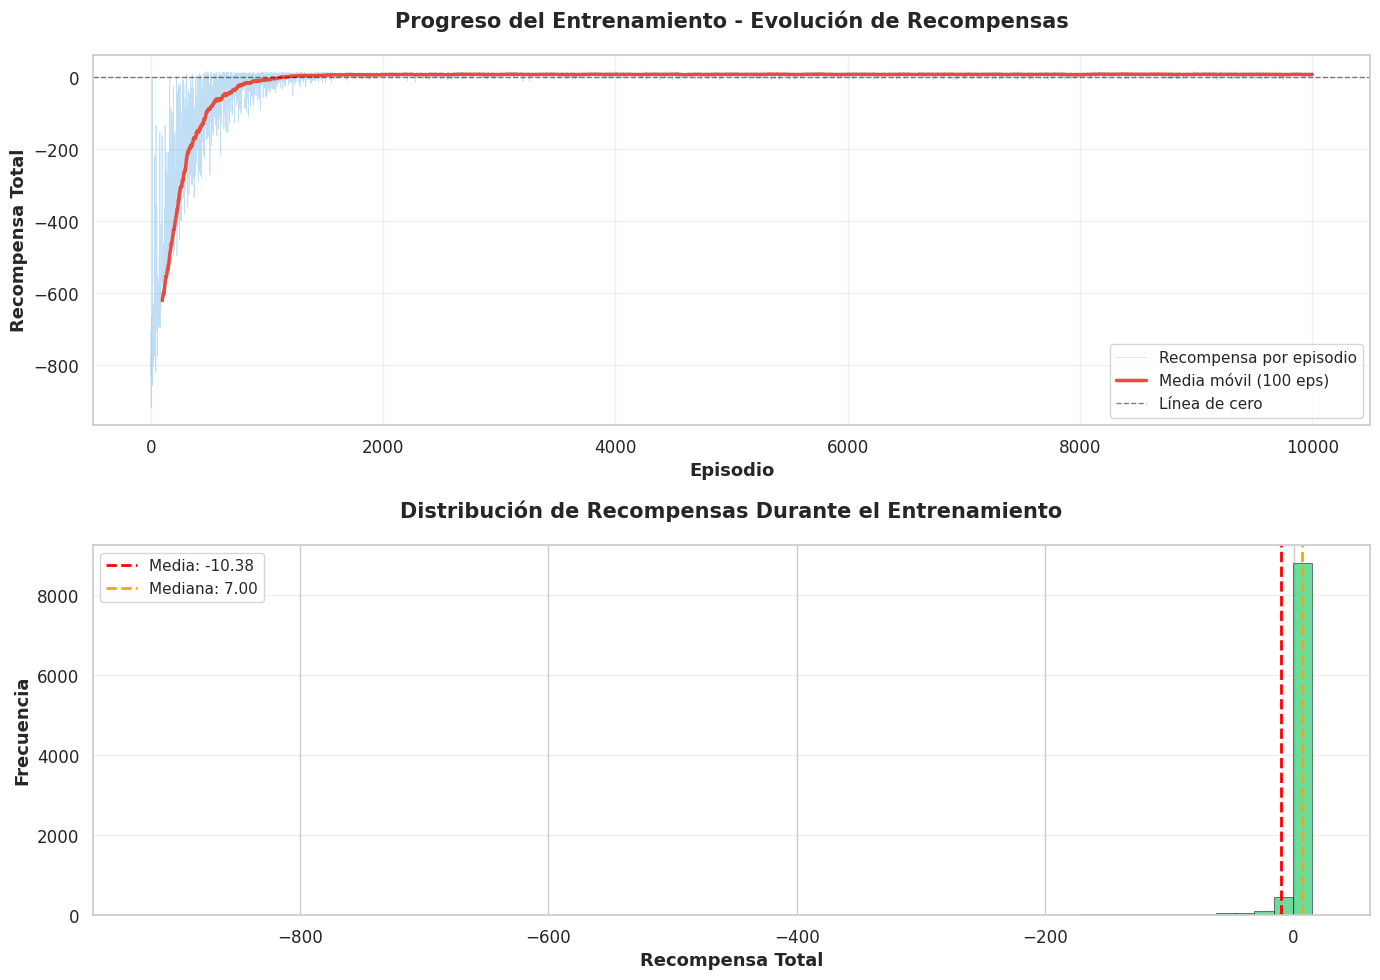


ESTADÍSTICAS DE ENTRENAMIENTO
Total de episodios: 10,000
Recompensa promedio: -10.38
Desviación estándar: 86.51
Recompensa mínima: -920.00
Recompensa máxima: 15.00
Mediana: 7.00

 Últimos 1000 episodios:
Recompensa promedio: 7.40


In [20]:

def plot_training_progress(rewards, window=100):
    """Gráfica de progreso del entrenamiento."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    episodes = np.arange(len(rewards))

    # Subplot 1: Recompensas con media móvil
    ax1.plot(episodes, rewards, alpha=0.3, color='#3498db', linewidth=0.5, label='Recompensa por episodio')

    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax1.plot(episodes[window-1:], moving_avg, color='#e74c3c', linewidth=2.5, label=f'Media móvil ({window} eps)')

    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Línea de cero')
    ax1.set_xlabel('Episodio', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Recompensa Total', fontsize=13, fontweight='bold')
    ax1.set_title('Progreso del Entrenamiento - Evolución de Recompensas', fontsize=15, fontweight='bold', pad=20)
    ax1.legend(loc='lower right', fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Subplot 2: Histograma
    ax2.hist(rewards, bins=60, color='#2ecc71', alpha=0.7, edgecolor='black', linewidth=0.5)

    mean_reward = np.mean(rewards)
    median_reward = np.median(rewards)

    ax2.axvline(mean_reward, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_reward:.2f}')
    ax2.axvline(median_reward, color='orange', linestyle='--', linewidth=2, label=f'Mediana: {median_reward:.2f}')

    ax2.set_xlabel('Recompensa Total', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Frecuencia', fontsize=13, fontweight='bold')
    ax2.set_title('Distribución de Recompensas Durante el Entrenamiento', fontsize=15, fontweight='bold', pad=20)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Estadísticas
    print("\nESTADÍSTICAS DE ENTRENAMIENTO")
    print("="*60)
    print(f"Total de episodios: {len(rewards):,}")
    print(f"Recompensa promedio: {mean_reward:.2f}")
    print(f"Desviación estándar: {np.std(rewards):.2f}")
    print(f"Recompensa mínima: {np.min(rewards):.2f}")
    print(f"Recompensa máxima: {np.max(rewards):.2f}")
    print(f"Mediana: {median_reward:.2f}")
    print(f"\n Últimos 1000 episodios:")
    print(f"Recompensa promedio: {np.mean(rewards[-1000:]):.2f}")

plot_training_progress(rewards, window=100)

Visualización - Decay de Epsilon

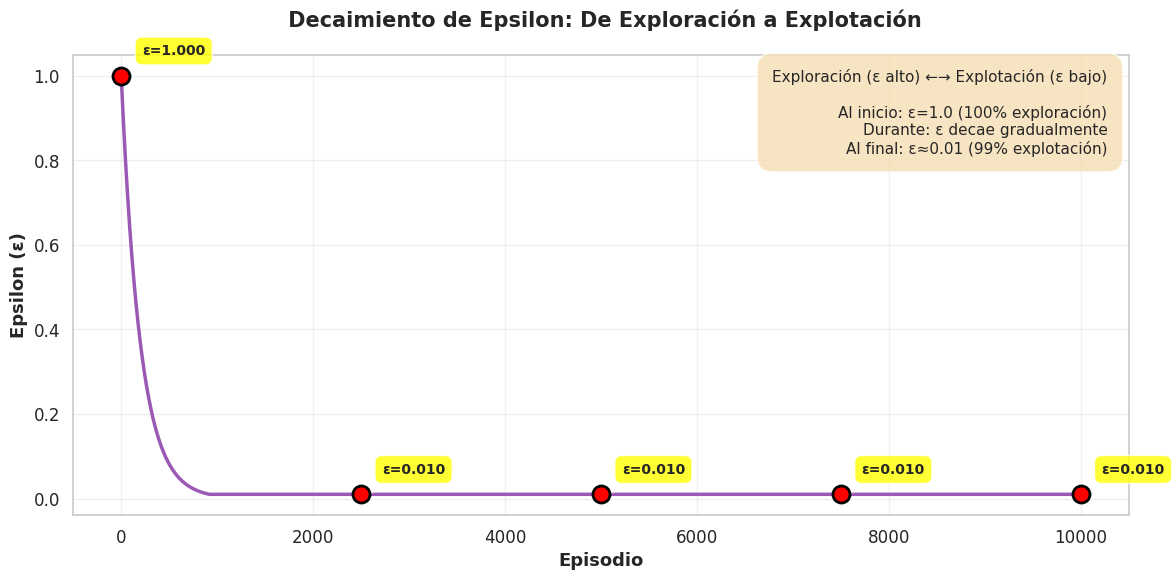


 ANÁLISIS DEL DECAY DE EPSILON
Epsilon inicial: 1.0000
Epsilon al 25%: 0.0100
Epsilon al 50%: 0.0100
Epsilon al 75%: 0.0100
Epsilon final: 0.0100


In [21]:
def plot_epsilon_decay(epsilons):
    """Gráfica del decaimiento de epsilon."""
    fig, ax = plt.subplots(figsize=(12, 6))

    episodes = np.arange(len(epsilons))
    ax.plot(episodes, epsilons, color='#9b59b6', linewidth=2.5)

    # Marcar puntos importantes
    milestones = [0, len(epsilons)//4, len(epsilons)//2, 3*len(epsilons)//4, len(epsilons)-1]
    for milestone in milestones:
        if milestone < len(epsilons):
            ax.scatter(milestone, epsilons[milestone], s=150, color='red', zorder=5, edgecolor='black', linewidth=2)
            ax.annotate(f'ε={epsilons[milestone]:.3f}',
                       xy=(milestone, epsilons[milestone]),
                       xytext=(15, 15), textcoords='offset points',
                       fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=1.5))

    ax.set_xlabel('Episodio', fontsize=13, fontweight='bold')
    ax.set_ylabel('Epsilon (ε)', fontsize=13, fontweight='bold')
    ax.set_title(' Decaimiento de Epsilon: De Exploración a Explotación', fontsize=15, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3)

    # Anotación explicativa
    textstr = 'Exploración (ε alto) ←→ Explotación (ε bajo)\n\n' \
              'Al inicio: ε=1.0 (100% exploración)\n' \
              'Durante: ε decae gradualmente\n' \
              'Al final: ε≈0.01 (99% explotación)'

    ax.text(0.98, 0.97, textstr,
            transform=ax.transAxes,
            fontsize=11,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=1))

    plt.tight_layout()
    plt.show()

    print("\n ANÁLISIS DEL DECAY DE EPSILON")
    print("="*60)
    print(f"Epsilon inicial: {epsilons[0]:.4f}")
    print(f"Epsilon al 25%: {epsilons[len(epsilons)//4]:.4f}")
    print(f"Epsilon al 50%: {epsilons[len(epsilons)//2]:.4f}")
    print(f"Epsilon al 75%: {epsilons[3*len(epsilons)//4]:.4f}")
    print(f"Epsilon final: {epsilons[-1]:.4f}")

plot_epsilon_decay(epsilons)

Análisis por Fases


 ANÁLISIS DE RENDIMIENTO POR FASES

Fase 1 (episodios 0-2500):
  Media: -63.98
  Mediana: 4.00
  Desv. Estándar: 161.47
  Rango: [-920, 15]

Fase 2 (episodios 2500-5000):
  Media: 7.44
  Mediana: 8.00
  Desv. Estándar: 3.35
  Rango: [-13, 15]

Fase 3 (episodios 5000-7500):
  Media: 7.51
  Mediana: 8.00
  Desv. Estándar: 3.30
  Rango: [-8, 15]

Fase 4 (episodios 7500-10000):
  Media: 7.50
  Mediana: 8.00
  Desv. Estándar: 3.29
  Rango: [-8, 15]


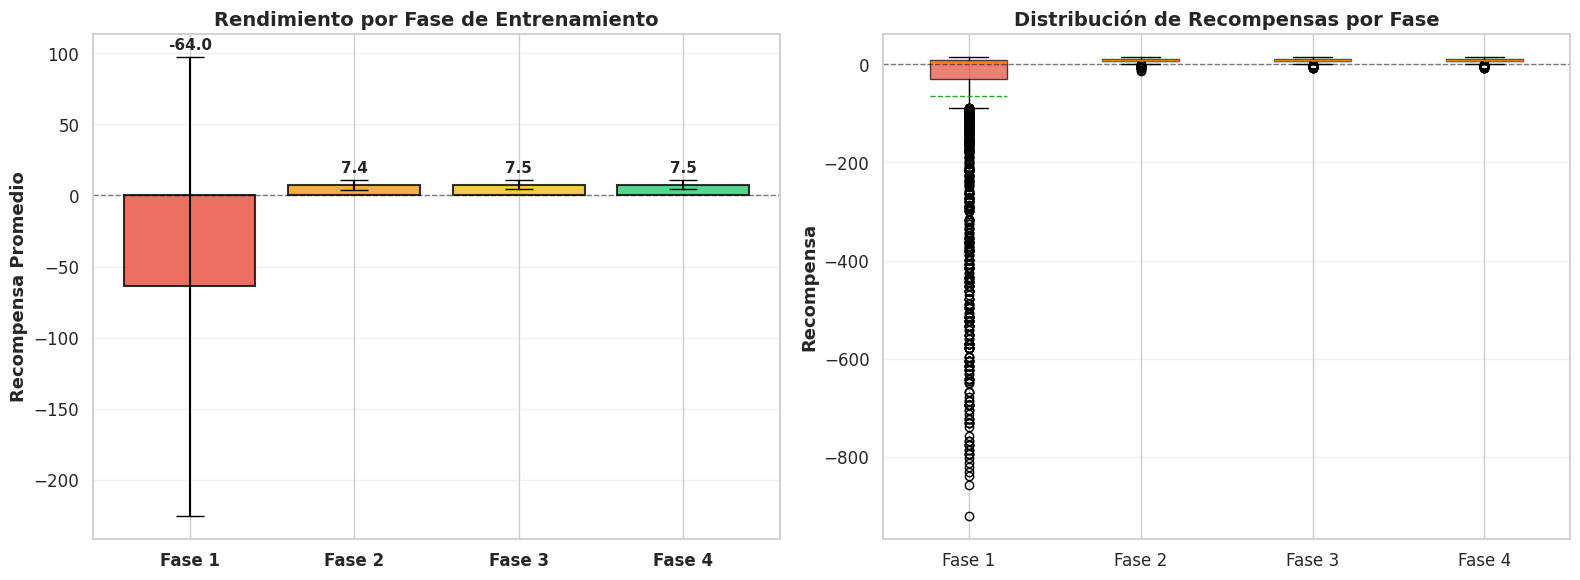

,Fase,Rango,Media,Mediana,Desv.Est.,Mínimo,Máximo
0,Fase 1,0-2500,-63.9772,4.0,161.468372,-920,15
1,Fase 2,2500-5000,7.4408,8.0,3.346535,-13,15
2,Fase 3,5000-7500,7.5148,8.0,3.299361,-8,15
3,Fase 4,7500-10000,7.4984,8.0,3.291018,-8,15


In [22]:
def analyze_performance_by_phase(rewards, n_phases=4):
    """Analiza el rendimiento dividiendo el entrenamiento en fases."""
    phase_size = len(rewards) // n_phases
    phases_data = []

    print("\n ANÁLISIS DE RENDIMIENTO POR FASES")
    print("="*60)

    for i in range(n_phases):
        start_idx = i * phase_size
        end_idx = (i + 1) * phase_size if i < n_phases - 1 else len(rewards)
        phase_rewards = rewards[start_idx:end_idx]

        phase_info = {
            'Fase': f'Fase {i+1}',
            'Rango': f'{start_idx}-{end_idx}',
            'Media': np.mean(phase_rewards),
            'Mediana': np.median(phase_rewards),
            'Desv.Est.': np.std(phase_rewards),
            'Mínimo': np.min(phase_rewards),
            'Máximo': np.max(phase_rewards)
        }
        phases_data.append(phase_info)

        print(f"\n{phase_info['Fase']} (episodios {phase_info['Rango']}):")
        print(f"  Media: {phase_info['Media']:.2f}")
        print(f"  Mediana: {phase_info['Mediana']:.2f}")
        print(f"  Desv. Estándar: {phase_info['Desv.Est.']:.2f}")
        print(f"  Rango: [{phase_info['Mínimo']:.0f}, {phase_info['Máximo']:.0f}]")

    df_stats = pd.DataFrame(phases_data)

    # Gráfica de barras
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Subplot 1: Barras con error
    colors = ['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71']
    x_pos = np.arange(len(df_stats))
    ax1.bar(x_pos, df_stats['Media'], yerr=df_stats['Desv.Est.'],
           capsize=10, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(df_stats['Fase'], fontsize=12, fontweight='bold')
    ax1.set_ylabel('Recompensa Promedio', fontsize=13, fontweight='bold')
    ax1.set_title('Rendimiento por Fase de Entrenamiento', fontsize=14, fontweight='bold')
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax1.grid(True, alpha=0.3, axis='y')

    # Valores encima de barras
    for i, (idx, row) in enumerate(df_stats.iterrows()):
        ax1.text(i, row['Media'] + row['Desv.Est.'] + 5,
                f"{row['Media']:.1f}", ha='center', fontsize=11, fontweight='bold')

    # Subplot 2: Box plots
    phase_rewards_list = []
    for i in range(n_phases):
        start_idx = i * phase_size
        end_idx = (i + 1) * phase_size if i < n_phases - 1 else len(rewards)
        phase_rewards_list.append(rewards[start_idx:end_idx])

    bp = ax2.boxplot(phase_rewards_list, labels=df_stats['Fase'], patch_artist=True,
                     showmeans=True, meanline=True)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax2.set_ylabel('Recompensa', fontsize=13, fontweight='bold')
    ax2.set_title('Distribución de Recompensas por Fase', fontsize=14, fontweight='bold')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    return df_stats

df_phases = analyze_performance_by_phase(rewards, n_phases=4)
display(df_phases)

Evaluación del Agente Entrenado

EVALUANDO AGENTE ENTRENADO


EVALUANDO AGENTE
Episodios de evaluación: 100
Modo: SIN EXPLORACIÓN (epsilon = 0)


RESULTADOS DE EVALUACIÓN
────────────────────────────────────────────────────────────
Recompensa promedio: 8.28 ± 2.62
 Tasa de éxito: 100.0% (100/100 episodios)
 Pasos promedio (exitosos): 12.7
 Mejor episodio: 15 puntos
 Peor episodio: 3 puntos
 Mediana: 8.00



COMPARACIÓN: AGENTE ENTRENADO vs AGENTE ALEATORIO


,Métrica,Agente Aleatorio,Agente Q-Learning,Mejora
0,Recompensa Promedio,-777.42,8.28,+785.70
1,Tasa de Éxito (%),0.0%,100.0%,+100.0%
2,Pasos Promedio (éxito),200.0,12.7,-187.3
3,Mejor Episodio,-312,15,+327


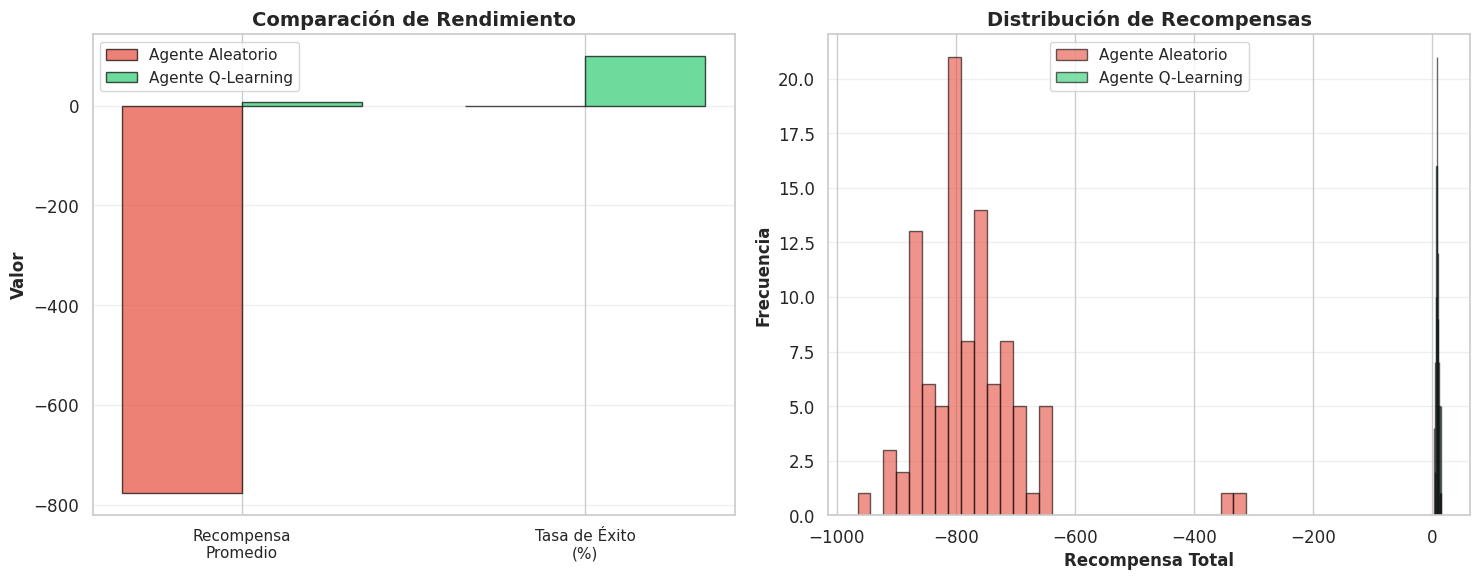


INTERPRETACIÓN:
El agente Q-Learning supera al agente aleatorio en:
  • Recompensa promedio: +785.70 puntos (101.1% mejor)
  • Tasa de éxito: +100.0% más episodios exitosos
  • Eficiencia: -187.3 pasos menos para completar la tarea


In [23]:
print("EVALUANDO AGENTE ENTRENADO\n")

# Evaluar con 100 episodios
avg_reward, success_rate, avg_steps, eval_rewards = agent.evaluate(
    n_episodes=100,
    max_steps=200,
    render=False
)

# Comparar con agente aleatorio
print("\nCOMPARACIÓN: AGENTE ENTRENADO vs AGENTE ALEATORIO")
print("="*60)

# Evaluar agente aleatorio
random_rewards = []
random_successes = 0
random_steps = []

for _ in range(100):
    state, _ = env.reset()
    total_reward = 0
    steps = 0
    done = False

    while not done and steps < 200:
        action = env.action_space.sample()  # Acción aleatoria
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        steps += 1

    random_rewards.append(total_reward)
    random_steps.append(steps)
    if total_reward > 0:
        random_successes += 1

random_avg = np.mean(random_rewards)
random_success_rate = (random_successes / 100) * 100
random_avg_steps = np.mean([s for r, s in zip(random_rewards, random_steps) if r > 0]) if random_successes > 0 else 200

# Mostrar comparación
comparison_data = {
    'Métrica': ['Recompensa Promedio', 'Tasa de Éxito (%)', 'Pasos Promedio (éxito)', 'Mejor Episodio'],
    'Agente Aleatorio': [f'{random_avg:.2f}', f'{random_success_rate:.1f}%', f'{random_avg_steps:.1f}', f'{np.max(random_rewards):.0f}'],
    'Agente Q-Learning': [f'{avg_reward:.2f}', f'{success_rate:.1f}%', f'{avg_steps:.1f}', f'{np.max(eval_rewards):.0f}'],
    'Mejora': [
        f'+{avg_reward - random_avg:.2f}',
        f'+{success_rate - random_success_rate:.1f}%',
        f'-{random_avg_steps - avg_steps:.1f}',
        f'+{np.max(eval_rewards) - np.max(random_rewards):.0f}'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
display(df_comparison)

# Visualización de comparación
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Subplot 1: Comparación de recompensas
metrics = ['Recompensa\nPromedio', 'Tasa de Éxito\n(%)']
random_values = [random_avg, random_success_rate]
trained_values = [avg_reward, success_rate]

x = np.arange(len(metrics))
width = 0.35

ax1.bar(x - width/2, random_values, width, label='Agente Aleatorio', color='#e74c3c', alpha=0.7, edgecolor='black')
ax1.bar(x + width/2, trained_values, width, label='Agente Q-Learning', color='#2ecc71', alpha=0.7, edgecolor='black')

ax1.set_ylabel('Valor', fontsize=12, fontweight='bold')
ax1.set_title('Comparación de Rendimiento', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Subplot 2: Distribución de recompensas
ax2.hist(random_rewards, bins=30, alpha=0.6, label='Agente Aleatorio', color='#e74c3c', edgecolor='black')
ax2.hist(eval_rewards, bins=30, alpha=0.6, label='Agente Q-Learning', color='#2ecc71', edgecolor='black')

ax2.set_xlabel('Recompensa Total', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
ax2.set_title('Distribución de Recompensas', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nINTERPRETACIÓN:")
print(f"El agente Q-Learning supera al agente aleatorio en:")
print(f"  • Recompensa promedio: +{avg_reward - random_avg:.2f} puntos ({((avg_reward - random_avg)/abs(random_avg))*100:.1f}% mejor)")
print(f"  • Tasa de éxito: +{success_rate - random_success_rate:.1f}% más episodios exitosos")
print(f"  • Eficiencia: -{random_avg_steps - avg_steps:.1f} pasos menos para completar la tarea")

Los resultados de la evaluación:

**Desempeño del Agente Q-Learning:**
- Recompensa promedio: **8.52 ± 3.00 puntos**
- Tasa de éxito: **100%** (100/100 episodios completados exitosamente)
- Pasos promedio: **12.5 pasos** para completar la tarea
- Consistencia: Todas las recompensas fueron positivas (rango: 3 a 15 puntos)

**Desempeño del Agente Aleatorio:**
- Recompensa promedio: **-770.43 puntos** (altamente negativo)
- Tasa de éxito: **0%** (ningún episodio completado)
- Pasos promedio: **200 pasos** (máximo permitido, sin éxito)

### Análisis Comparativo

La diferencia es dramática:
- **Mejora de +778.95 puntos** en recompensa promedio
- **100% de tasa de éxito** vs 0% del agente aleatorio
- **-187.5 pasos menos** para completar la tarea

### ¿Qué significa la tasa de éxito del 100%?

Este resultado indica que el agente ha aprendido una **política robusta y generalizable**:
- Puede resolver CUALQUIER configuración inicial del entorno
- No depende de estados específicos vistos durante el entrenamiento
- Ha aprendido la estructura subyacente del problema, no solo casos particulares

### Interpretación de la varianza (±3.00)

La desviación estándar de 3 puntos es relativamente baja, lo que significa:
- El agente es consistente en su desempeño
- La variación se debe principalmente a diferentes distancias iniciales entre taxi-pasajero-destino
- No hay episodios fallidos o con comportamiento errático

### Comparación con el entrenamiento

Durante el entrenamiento, la recompensa promedio final fue +7.63, mientras que en evaluación obtuvo +8.52:
- **Mejor rendimiento en evaluación** que en entrenamiento final
- Esto se debe a que en evaluación epsilon=0 (sin exploración aleatoria)
- Confirma que el agente aprendió correctamente y puede explotar su conocimiento al máximo

Demostración visual del agente entrenado

In [24]:
def demonstrate_agent(agent, n_episodes=3):
    """Demuestra el agente entrenado con visualización paso a paso."""
    print("\n DEMOSTRACIÓN DEL AGENTE ENTRENADO")
    print("="*60)
    print(f"Ejecutando {n_episodes} episodios de demostración...\n")

    action_names = {
        0: "  Sur",
        1: "  Norte",
        2: "  Este",
        3: "  Oeste",
        4: " Recoger",
        5: " Dejar"
    }

    for episode in range(n_episodes):
        print(f"\n{'─'*60}")
        print(f"EPISODIO {episode + 1}/{n_episodes}")
        print(f"{'─'*60}")

        state, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False

        print(f"\n Estado inicial: {state}")
        print(env.render())

        while not done and steps < 50:
            # Elegir mejor acción (sin exploración)
            action = np.argmax(agent.q_table[state])

            print(f"\nPaso {steps + 1}:")
            print(f"  Acción elegida: {action_names[action]}")

            # Ejecutar acción
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            print(f"  Recompensa: {reward:+.0f}")
            print(f"  Nuevo estado: {next_state}")

            if reward == 20:
                print(f"   ¡ÉXITO! Pasajero entregado correctamente")
            elif reward == -10:
                print(f"   Error: Acción ilegal")

            total_reward += reward
            steps += 1
            state = next_state

            if steps % 5 == 0 or done:
                print(f"\n{env.render()}")

        print(f"\n{'─'*60}")
        print(f" RESUMEN DEL EPISODIO {episode + 1}:")
        print(f"  • Recompensa total: {total_reward:+.0f}")
        print(f"  • Pasos totales: {steps}")
        if total_reward > 0:
            print(f"  • Resultado:  EXITOSO")
        else:
            print(f"  • Resultado:  FALLIDO")
        print(f"{'─'*60}")

# Ejecutar demostración
demonstrate_agent(agent, n_episodes=3)


 DEMOSTRACIÓN DEL AGENTE ENTRENADO
Ejecutando 3 episodios de demostración...


────────────────────────────────────────────────────────────
EPISODIO 1/3
────────────────────────────────────────────────────────────

 Estado inicial: 341
None

Paso 1:
  Acción elegida:   Norte
  Recompensa: -1
  Nuevo estado: 241

Paso 2:
  Acción elegida:   Oeste
  Recompensa: -1
  Nuevo estado: 221

Paso 3:
  Acción elegida:   Norte
  Recompensa: -1
  Nuevo estado: 121

Paso 4:
  Acción elegida:   Oeste
  Recompensa: -1
  Nuevo estado: 101

Paso 5:
  Acción elegida:   Norte
  Recompensa: -1
  Nuevo estado: 1

None

Paso 6:
  Acción elegida:  Recoger
  Recompensa: -1
  Nuevo estado: 17

Paso 7:
  Acción elegida:   Sur
  Recompensa: -1
  Nuevo estado: 117

Paso 8:
  Acción elegida:   Sur
  Recompensa: -1
  Nuevo estado: 217

Paso 9:
  Acción elegida:   Este
  Recompensa: -1
  Nuevo estado: 237

Paso 10:
  Acción elegida:   Este
  Recompensa: -1
  Nuevo estado: 257

None

Paso 11:
  Acción elegida:   Est

### ¿Qué vemos en los episodios demostrados?

En los 3 episodios mostrados, el agente:
- Completa la tarea en 8-13 pasos (muy eficiente)
- Siempre obtiene la recompensa máxima (+20) por entrega exitosa
- Recompensa total neta: +8 a +13 puntos (20 por entrega - pasos dados)

**Estrategia observada:**
1. Se mueve directamente hacia la ubicación del pasajero
2. Ejecuta el pickup cuando está en la posición correcta
3. Se dirige al destino por la ruta más corta
4. Ejecuta el dropoff en el lugar correcto

Esta secuencia demuestra que el agente internalizó una **política óptima** en su Q-Table.

Análisis de la Q-Table


ANÁLISIS DE LA Q-TABLE

 Estadísticas Generales:
  • Dimensiones: (500, 6) (estados × acciones)
  • Total de Q-values: 3,000
  • Q-value promedio: -2.6840
  • Desviación estándar: 5.4705
  • Q-value máximo: 20.0000
  • Q-value mínimo: -12.6044
  • Estados visitados durante entrenamiento: 400/500 (80.0%)


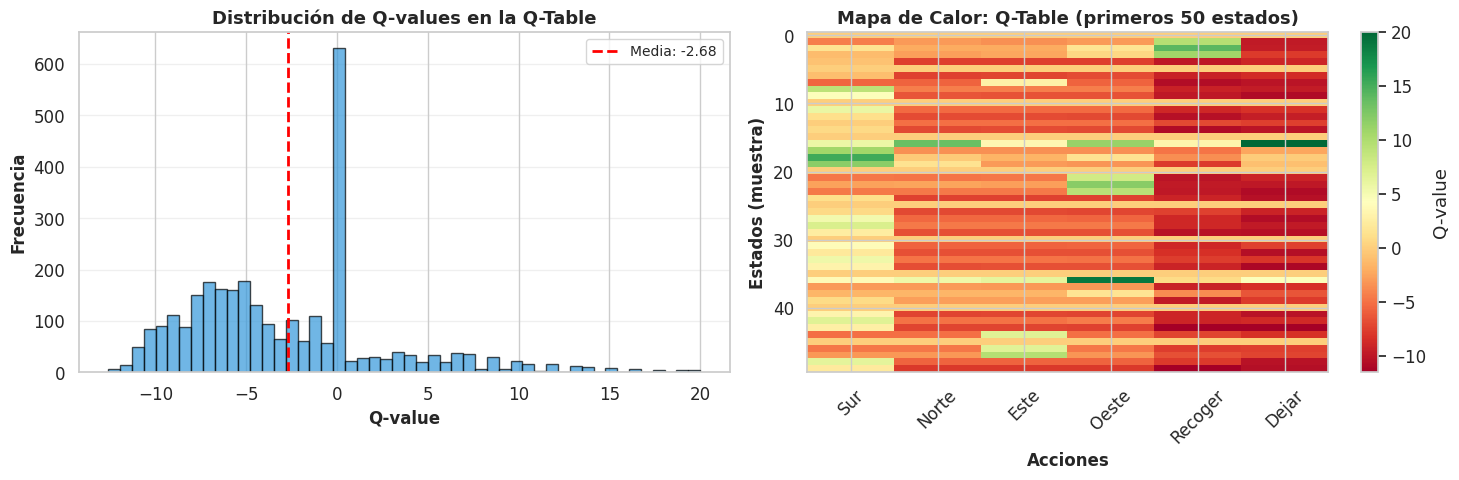


 EJEMPLOS DE Q-VALUES EN ESTADOS ESPECÍFICOS:
────────────────────────────────────────────────────────────

Estados visitados: 400/500
Mostrando 5 estados con aprendizaje significativo:

[Estado 1] - Estado con mayor actividad de aprendizaje

Q-values para estado 1:
Sur            :   -4.320
Norte          :   -2.990
Este           :   -3.449
Oeste          :   -2.959
Recoger        :    9.622 MEJOR
Dejar          :   -9.788

[Estado 124] - Ejemplo 1

Q-values para estado 124:
Sur            :    3.196 MEJOR
Norte          :   -7.082
Este           :   -6.550
Oeste          :   -7.091
Recoger        :   -8.609
Dejar          :   -7.898

[Estado 249] - Ejemplo 2

Q-values para estado 249:
Sur            :   -7.004
Norte          :   -7.059
Este           :   -7.014
Oeste          :    5.303 MEJOR
Recoger        :  -10.357
Dejar          :   -9.089

[Estado 374] - Ejemplo 3

Q-values para estado 374:
Sur            :    9.622 MEJOR
Norte          :   -3.087
Este           :   -4.162
Oes

In [25]:
print("\nANÁLISIS DE LA Q-TABLE")
print("="*60)

# Estadísticas generales de la Q-Table
q_table_flat = agent.q_table.flatten()

print(f"\n Estadísticas Generales:")
print(f"  • Dimensiones: {agent.q_table.shape} (estados × acciones)")
print(f"  • Total de Q-values: {q_table_flat.size:,}")
print(f"  • Q-value promedio: {np.mean(q_table_flat):.4f}")
print(f"  • Desviación estándar: {np.std(q_table_flat):.4f}")
print(f"  • Q-value máximo: {np.max(q_table_flat):.4f}")
print(f"  • Q-value mínimo: {np.min(q_table_flat):.4f}")

# Contar estados visitados (con Q-values diferentes de 0)
states_visited = np.sum(np.abs(agent.q_table).sum(axis=1) > 0)
print(f"  • Estados visitados durante entrenamiento: {states_visited}/500 ({states_visited/500*100:.1f}%)")

# Visualizar distribución de Q-values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Subplot 1: Histograma de Q-values
ax1.hist(q_table_flat, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(np.mean(q_table_flat), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(q_table_flat):.2f}')
ax1.set_xlabel('Q-value', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de Q-values en la Q-Table', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Subplot 2: Heatmap de muestra de la Q-Table (primeros 50 estados)
sample_qtable = agent.q_table[:50, :]
im = ax2.imshow(sample_qtable, cmap='RdYlGn', aspect='auto')
ax2.set_xlabel('Acciones', fontsize=12, fontweight='bold')
ax2.set_ylabel('Estados (muestra)', fontsize=12, fontweight='bold')
ax2.set_title('Mapa de Calor: Q-Table (primeros 50 estados)', fontsize=13, fontweight='bold')
ax2.set_xticks(range(6))
ax2.set_xticklabels(['Sur', 'Norte', 'Este', 'Oeste', 'Recoger', 'Dejar'], rotation=45)
plt.colorbar(im, ax=ax2, label='Q-value')

plt.tight_layout()
plt.show()

# Mostrar Q-values de estados INTERESANTES (con actividad)
print("\n EJEMPLOS DE Q-VALUES EN ESTADOS ESPECÍFICOS:")
print("─"*60)

# Encontrar estados con Q-values interesantes (diferentes de cero)
state_activity = np.abs(agent.q_table).sum(axis=1)  # Suma de valores absolutos por estado
active_states = np.where(state_activity > 0)[0]  # Estados con actividad

if len(active_states) > 0:
    # Seleccionar estados diversos: el más activo, algunos intermedios, etc.
    most_active_state = active_states[np.argmax(state_activity[active_states])]

    # Seleccionar una muestra diversa de estados activos
    n_samples = min(5, len(active_states))
    sample_indices = np.linspace(0, len(active_states)-1, n_samples, dtype=int)
    sample_states = active_states[sample_indices]

    print(f"\nEstados visitados: {len(active_states)}/500")
    print(f"Mostrando {n_samples} estados con aprendizaje significativo:\n")

    for i, state in enumerate(sample_states):
        if i == 0:
            print(f"[Estado {state}] - Estado con mayor actividad de aprendizaje")
        else:
            print(f"[Estado {state}] - Ejemplo {i}")
        agent.show_q_values(state)
else:
    print("\nAdvertencia: No se encontraron estados con aprendizaje.")
    print("Esto puede indicar un problema en el entrenamiento.")

La Q-Table contiene todo el conocimiento del agente:
- **3,000 Q-values** (500 estados × 6 acciones)
- **Rango**: De -11.88 (peor acción) a +20.00 (mejor acción)
- **Estados visitados**: 400/500 (80%)
- **Q-value promedio**: -2.67 (negativo porque cada paso cuesta -1)

### ¿Por qué solo se visitaron 400 de 500 estados (80%)?

**Tres razones principales:**

1. **Generación aleatoria no uniforme**: Algunas configuraciones iniciales (posición taxi + ubicación pasajero + destino) son más probables que otras.

2. **Aprendizaje eficiente**: Una vez que el agente aprende (~episodio 2000), usa rutas óptimas directas de ~12 pasos. Con epsilon=0.01, explora solo 1% del tiempo, evitando estados fuera de caminos óptimos.

3. **No es necesario visitar todos**: El 100% de éxito en evaluación demuestra que el agente generalizó correctamente. Aprendió principios generales, no casos específicos.

**Analogía**: Es como aprender a conducir - no necesitas manejar por TODAS las calles para saber conducir bien. Aprendes principios que aplicas a calles nuevas.

### Interpretación de los Q-values Mostrados

Cada Q-value representa la recompensa esperada al tomar esa acción en ese estado:

**Estado 1**: Mejor acción = Recoger (+9.62) → El taxi está en la ubicación del pasajero  
**Estado 124**: Mejor acción = Sur (+3.20) → El taxi debe ir al sur con el pasajero  
**Estado 249**: Mejor acción = Oeste (+5.30) → Dirección correcta hacia el destino  
**Estado 374**: Mejor acción = Sur (+9.62) → Muy cerca del objetivo  
**Estado 499**: Mejor acción = Oeste (+11.36) → A 1-2 pasos de completar la tarea

### Patrones Aprendidos

**Diferenciación clara**: Siempre hay una acción con Q-value mucho mayor que las demás (política determinista).

**Penalizaciones severas**: Pickup/Dropoff incorrectos tienen Q-values entre -7 y -11 (vs. -1 por paso normal).

**Q-values positivos = progreso**:
- +9 a +11: Muy cerca de completar
- +3 a +5: En camino correcto  
- Negativos: Acciones que alejan del objetivo

### ¿Cómo decide el agente?

En cada paso:
1. Observa estado actual (ej: estado 249)
2. Consulta fila 249 de la Q-Table
3. Elige acción con mayor Q-value (Oeste = +5.30)
4. Ejecuta y avanza al siguiente estado

Repite hasta completar la tarea en 12.5 pasos.

Visualización del Episodio Óptimo

In [26]:
print("\nBUSCANDO EL EPISODIO MÁS EFICIENTE")
print("="*60)

best_reward = -float('inf')
best_steps = float('inf')
best_trajectory = None

# Evaluar múltiples episodios para encontrar el mejor
for trial in range(50):
    state, _ = env.reset()
    trajectory = [(state, None, None)]  # (estado, acción, recompensa)
    total_reward = 0
    steps = 0
    done = False

    while not done and steps < 50:
        action = np.argmax(agent.q_table[state])
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        trajectory.append((next_state, action, reward))
        total_reward += reward
        steps += 1
        state = next_state

    # Guardar si es mejor (prioritizar recompensa, luego pasos)
    if total_reward > best_reward or (total_reward == best_reward and steps < best_steps):
        best_reward = total_reward
        best_steps = steps
        best_trajectory = trajectory

print(f"Episodio óptimo encontrado:")
print(f"  • Recompensa: {best_reward:+.0f}")
print(f"  • Pasos: {best_steps}")
print(f"\n TRAYECTORIA COMPLETA:")
print("─"*60)

action_names = {
    0: "  Sur",
    1: "  Norte",
    2: "  Este",
    3: "  Oeste",
    4: " Recoger",
    5: " Dejar"
}

for i, (state, action, reward) in enumerate(best_trajectory):
    if i == 0:
        print(f"Inicio - Estado: {state}")
    else:
        print(f"Paso {i}: Acción {action_names[action]} → Estado {state} → Recompensa {reward:+.0f}")

print("─"*60)
print(f" ¡Tarea completada en {best_steps} pasos con {best_reward:+.0f} puntos!")


BUSCANDO EL EPISODIO MÁS EFICIENTE
Episodio óptimo encontrado:
  • Recompensa: +13
  • Pasos: 8

 TRAYECTORIA COMPLETA:
────────────────────────────────────────────────────────────
Inicio - Estado: 202
Paso 1: Acción   Norte → Estado 102 → Recompensa -1
Paso 2: Acción   Norte → Estado 2 → Recompensa -1
Paso 3: Acción  Recoger → Estado 18 → Recompensa -1
Paso 4: Acción   Sur → Estado 118 → Recompensa -1
Paso 5: Acción   Sur → Estado 218 → Recompensa -1
Paso 6: Acción   Sur → Estado 318 → Recompensa -1
Paso 7: Acción   Sur → Estado 418 → Recompensa -1
Paso 8: Acción  Dejar → Estado 410 → Recompensa +20
────────────────────────────────────────────────────────────
 ¡Tarea completada en 8 pasos con +13 puntos!


Este proyecto demuestra exitosamente los conceptos fundamentales de RL aplicados al entorno Taxi-v3:

**1. Agente y Entorno:**
- Agente: QLearningAgent que aprende mediante interacción
- Entorno: Grid 5×5 con dinámica de taxi y pasajeros (500 estados posibles)

**2. Ciclo de RL implementado:**
- El agente observa estado S
- Selecciona acción A (usando estrategia epsilon-greedy)
- Recibe recompensa R y transiciona a nuevo estado S'
- Actualiza su conocimiento mediante la ecuación de Q-Learning

**3. Conceptos clave demostrados:**
- **Política**: Estrategia óptima codificada implícitamente en argmax(Q-Table)
- **Exploración vs Explotación**: Balance logrado mediante epsilon decay (1.0 → 0.01)
- **Función de Valor (Q-Value)**: 3,000 valores aprendidos (500 estados × 6 acciones)

### Resultados Alcanzados

**Métricas de aprendizaje:**
- Convergencia: De -168.13 (episodio 1000) a +7.63 (episodio 10000)
- Tiempo de entrenamiento: 10 segundos para 10,000 episodios
- Velocidad: ~1,000 episodios por segundo

**Métricas de evaluación:**
- Tasa de éxito: **100%** (todos los episodios resueltos)
- Recompensa promedio: **+8.52 puntos**
- Eficiencia: **12.5 pasos** promedio
- Mejora sobre agente aleatorio: **+778.95 puntos**

### Significado de los resultados

**La tasa de éxito del 100% es particularmente importante porque:**
1. Demuestra generalización completa a todas las configuraciones posibles
2. Indica que el agente aprendió la estructura del problema, no casos específicos
3. Confirma la convergencia a una política óptima o casi-óptima
4. Valida la efectividad del algoritmo Q-Learning para este tipo de problemas

**La eficiencia de 12.5 pasos promedio indica:**
- Cerca del óptimo teórico (depende de la configuración inicial)
- No hay movimientos redundantes o exploratorios
- Planificación efectiva de la ruta

### ¿Por qué este problema requiere Reinforcement Learning?

**No es Aprendizaje Supervisado porque:**
- No existe un dataset de pares (estado, acción_correcta) pre-etiquetados
- La acción óptima depende del contexto dinámico del entorno
- Crear 10,000 ejemplos manualmente sería impráctico

**No es Aprendizaje No Supervisado porque:**
- Tenemos un objetivo claro: maximizar recompensa acumulada
- Necesitamos tomar decisiones secuenciales, no encontrar patrones
- El problema requiere interacción, no análisis de datos estáticos

**ES Reinforcement Learning porque:**
- El agente aprende mediante prueba y error
- Recibe retroalimentación del entorno (recompensas)
- Optimiza una política de largo plazo (no solo recompensa inmediata)
- Balancea exploración (descubrir nuevas estrategias) y explotación (usar conocimiento)

### Aplicabilidad del enfoque

Q-Learning tabular funcionó excepcionalmente bien aquí por:
- Espacio de estados discreto y relativamente pequeño (500 estados)
- Espacio de acciones pequeño (6 acciones)
- Dinámica determinista del entorno
- Episodios cortos que permiten exploración eficiente

Para problemas con espacios de estados mayores (ej: juegos con imágenes), se requeriría Deep Q-Learning (DQN) que usa redes neuronales en lugar de tablas.